In [1]:
from numba import jit, njit, config, __version__, errors
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# PDF 1

## Funções

In [2]:
@jit(nopython=True)
def vizinhos(N):
  #Define a tabela de vizinhos
  L=int(np.sqrt(N))
  viz = np.zeros((N,4),dtype=np.int16)
  for k in range(N):
    viz[k,0]=k+1
    if (k+1) % L == 0: viz[k,0] = k+1-L
    viz[k,1] = k+L
    if k > (N-L-1): viz[k,1] = k+L-N
    viz[k,2] = k-1
    if (k % L == 0): viz[k,2] = k+L-1
    viz[k,3] = k-L
    if k < L: viz[k,3] = k+N-L
  return viz

In [3]:
@jit(nopython=True)
def calcular_energia(s,viz):
  #Calcula a energia da configuração representada no array s
  N=len(s)
  ener = 0
  for i in range(N):
    h = s[viz[i,0]]+s[viz[i,1]] # soma do valor dos spins a direita e acima
    ener -= s[i]*h
  return ener

In [4]:
@jit(nopython=True)
def calcular_magnetizacao(s):
  return sum(s)

In [5]:
@jit(nopython=True)
def expos(beta):
  ex = np.zeros(5,dtype=np.float32)
  ex[0]=np.exp(8.0*beta)
  ex[1]=np.exp(4.0*beta)
  ex[2]=1.0
  ex[3]=np.exp(-4.0*beta)
  ex[4]=np.exp(-8.0*beta)
  return ex

In [6]:
def alg_metropolis(L, temp_inicial, n_passos = 1000, s = None):
  tam_rede = (L ** 2)  # Entre 24 ** 2 e 100 ** 2
  beta = 1/temp_inicial
  ex = expos(beta)
  if not s:
    s = [random.choice([-1, 1]) for _ in range(tam_rede)]
  viz = vizinhos(tam_rede)
  energias = np.zeros(n_passos)
  energia_atual = calcular_energia(s, viz)
  magnetizacoes = np.zeros(n_passos)
  magnetizacao_atual = calcular_magnetizacao(s)
  magnetizacao_atual = 0
  for iter in range(n_passos * tam_rede):
    i = random.randint(0, tam_rede-1)
    h = s[viz[i,0]]+s[viz[i,1]]+s[viz[i,2]]+s[viz[i,3]] # soma dos vizinhos
    de = int(s[i]*h*0.5+2)
    P = ex[de]
    r = random.uniform(0, 1)
    if (r <= P):
      energia_atual += 2 * s[i] * h
      magnetizacao_atual = magnetizacao_atual + (-1) * 2 * s[i]
      s[i] = -s[i]
    else:
      pass
    if (iter % tam_rede == 0):
      energias[int(iter/tam_rede)] = energia_atual
      magnetizacoes[int(iter/tam_rede)] = magnetizacao_atual
  return energias, magnetizacoes

In [7]:
def fazer_alg_metropolis_n_vezes(n, L, temp_inicial, n_passos = 1000, s = None):
  arr_energias = np.zeros((n,n_passos))
  arr_magnetizacoes = np.zeros((n,n_passos))
  for i in range(n):
    arr_energias[i], arr_magnetizacoes[i] = alg_metropolis(L, temp_inicial, n_passos, s)
  return arr_energias, arr_magnetizacoes

In [8]:
def plotar_grafo_linha(arr_dados, label_x, label_y, title = ""):
  x = range(len(arr_dados[0]))
  for y in arr_dados:
    plt.plot(x, y)

  # Add labels and a title
  plt.xlabel(label_x)
  plt.ylabel(label_y)
  plt.title(title)

  # Display the plot
  plt.show()


1) Gere uma configuração inicial para o sistema (aleatória, por exemplo).\
2) Escolha um dos spins da rede (𝑆").\
3) Determine a diferença de energia caso o spin 𝑆" fosse flipado, Δ𝐸.\
4) Calcule 𝑃 = 𝑒^(-beta * del_E), e compare com um número aleatório, 𝑟, uniformemente
distribuído no intervalo (0,1).\
    a. Se 𝑟 ≤ 𝑃, aceite a nova configuração, ou seja, flipe o spin fazendo 𝑆" =
−𝑆".\
    b. Se 𝑟 > 𝑃, mantenha o sistema na configuração em que ele se
encontrava.\
5) Volte ao passo 2.\


## Testes

In [9]:
L = 32
N = L**2
temp_inicial = 1.5
beta = 1 / temp_inicial
n_passos = 1000
n = 5
arr_energias, arr_magnetizacoes = fazer_alg_metropolis_n_vezes(n, L, temp_inicial, n_passos)

/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 's' of function 'calcular_energia'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-3-41b5d7db27bd>", line 2:
@jit(nopython=True)
def calcular_energia(s,viz):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
<ipython-input-4-5d4296837601>:3: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'iterable' of function 'ol_sum.<locals>.impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/python3.10/dist-packages/numba/cpython/builtins.py", line 692:



In [10]:
print(arr_energias.shape)
print(len(arr_energias[0]))

(5, 1000)
1000


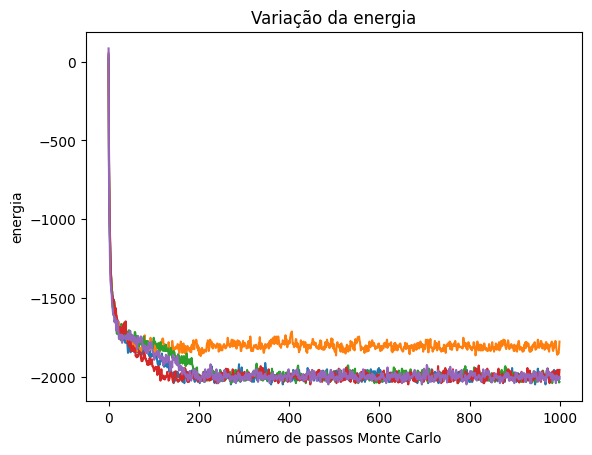

In [11]:
plotar_grafo_linha(arr_energias, "número de passos Monte Carlo", "energia", "Variação da energia")

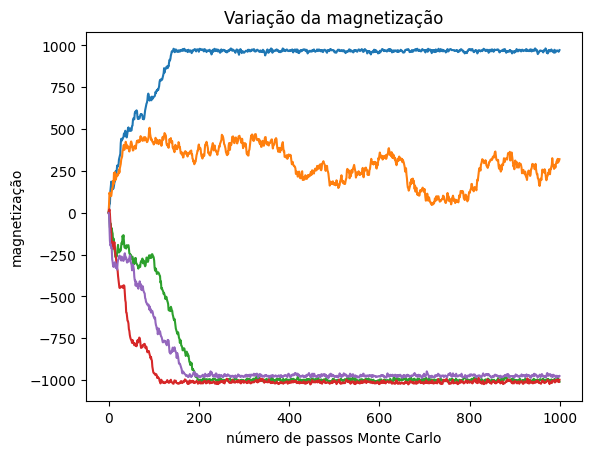

In [12]:
plotar_grafo_linha(arr_magnetizacoes, "número de passos Monte Carlo", "magnetização", "Variação da magnetização")

In [13]:
L = 32
temp_inicial = 0.4
limit=3.0
step=0.2
n_passos = 1000
n = 5
for temp in range(int(temp_inicial*100),int(limit*100+1),int(step*100)):
    temp=temp/100
    if (temp==temp_inicial):
        arr_energias, arr_magnetizacoes = fazer_alg_metropolis_n_vezes(n, L, temp, n_passos)
    else:
        arr_energias_aux, arr_magnetizacoes_aux = fazer_alg_metropolis_n_vezes(n, L, temp, n_passos)
        arr_energias=np.concatenate((arr_energias,arr_energias_aux),0)
        arr_magnetizacoes=np.concatenate((arr_magnetizacoes,arr_magnetizacoes_aux),0)

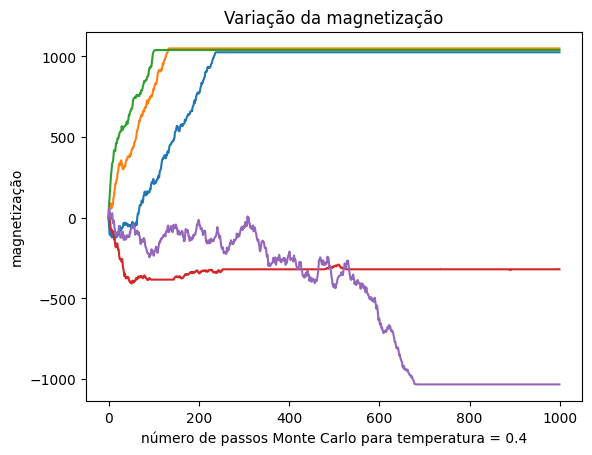

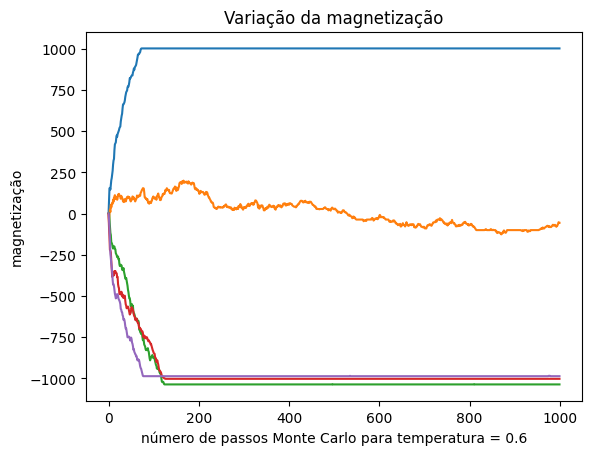

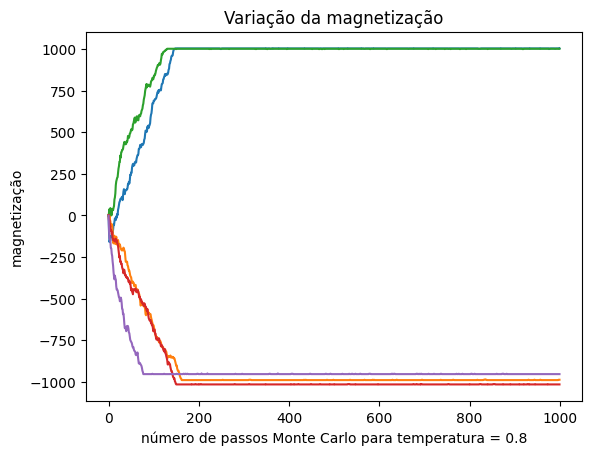

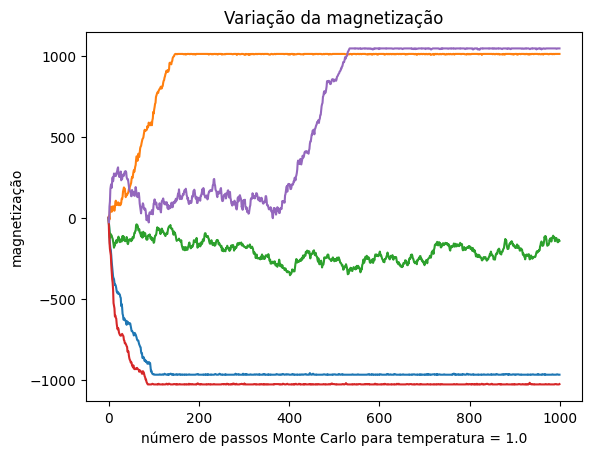

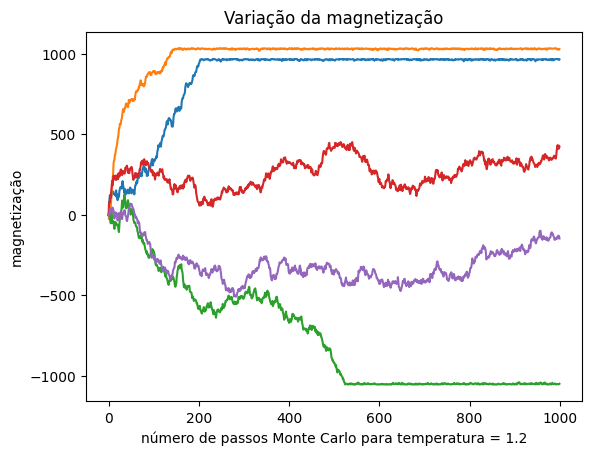

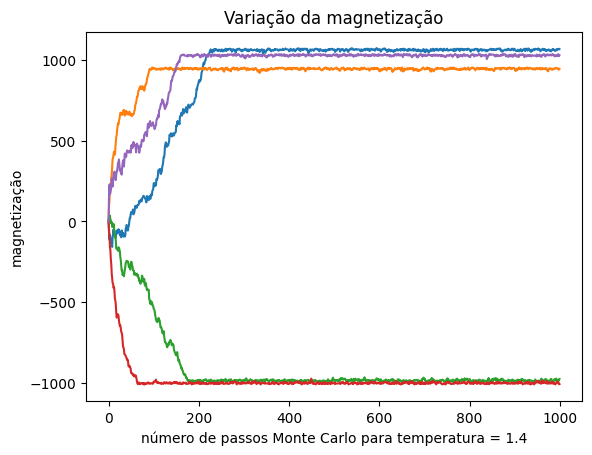

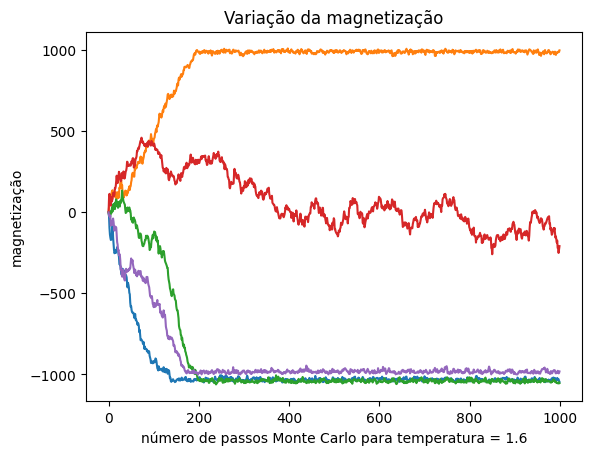

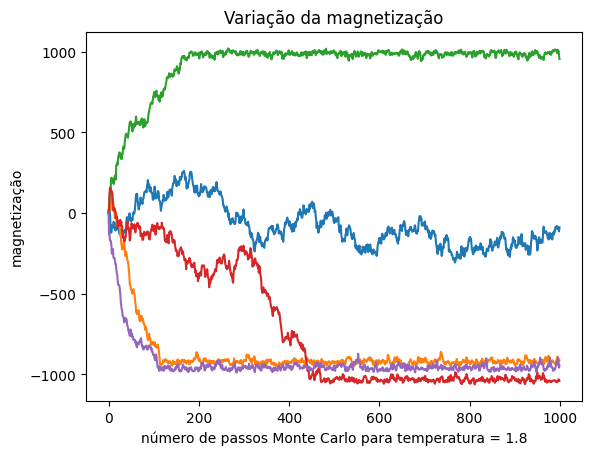

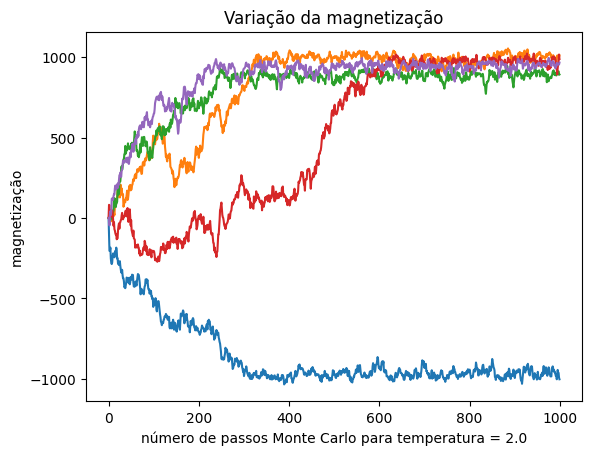

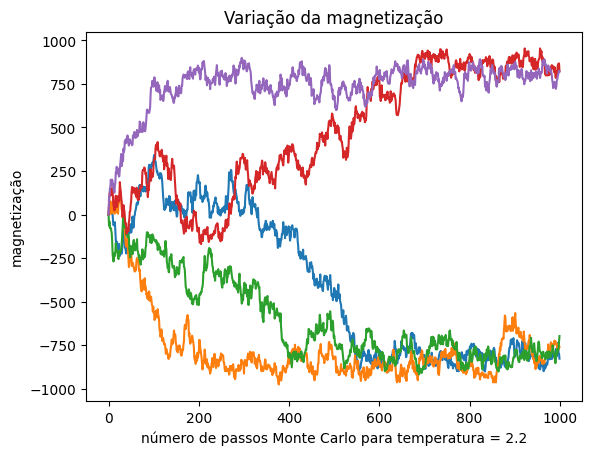

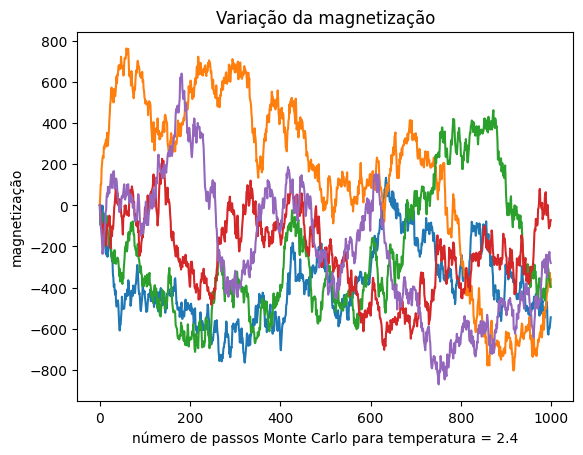

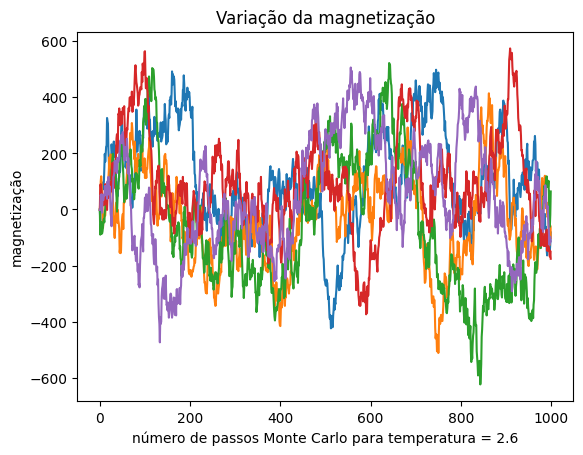

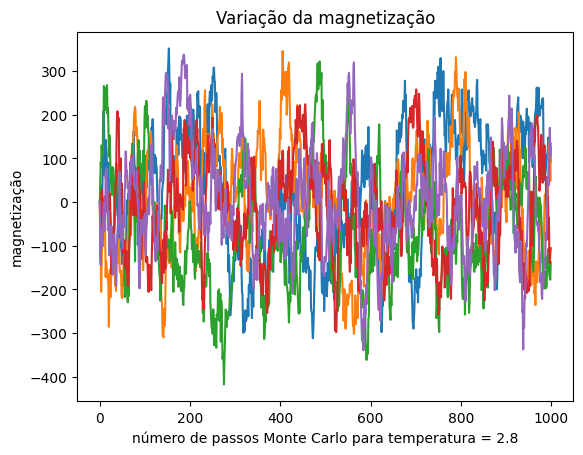

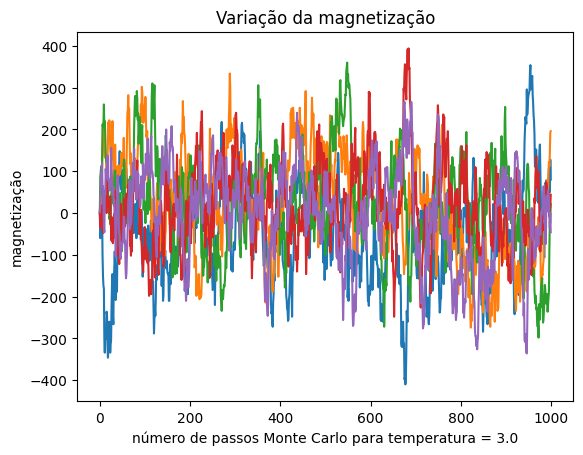

In [14]:
temp=temp_inicial
for i in range(0,arr_energias.shape[0],n):
    plotar_grafo_linha(arr_magnetizacoes[i:i+n], "número de passos Monte Carlo para temperatura = " + str(round(temp,2)), "magnetização", "Variação da magnetização")
    temp=temp+step

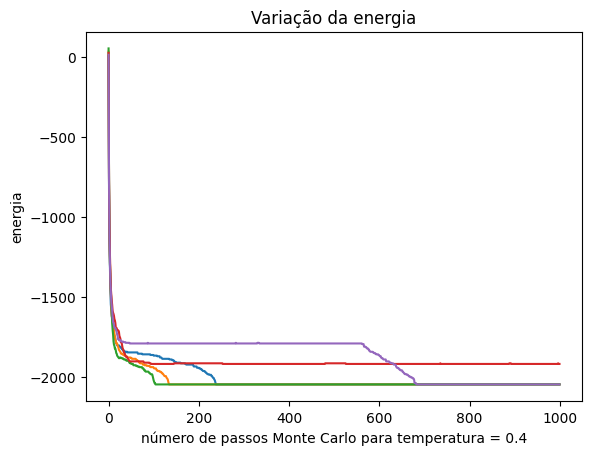

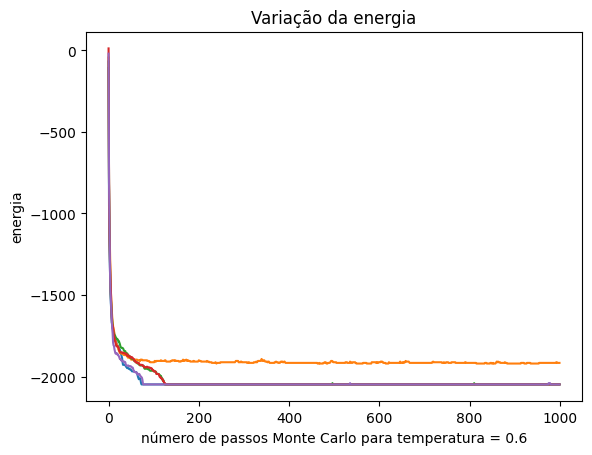

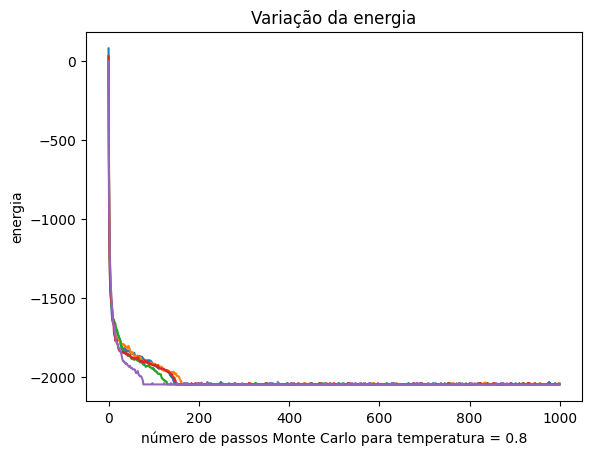

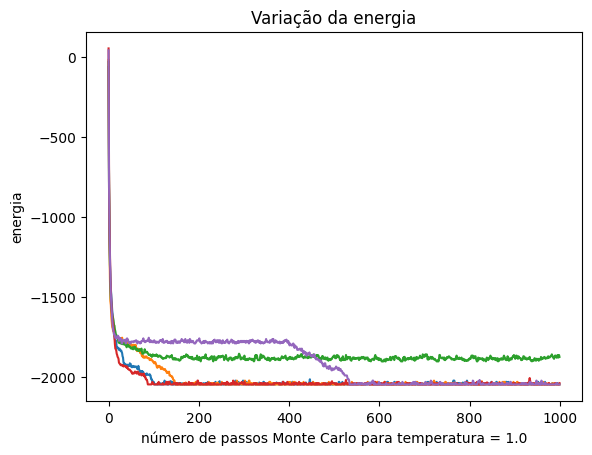

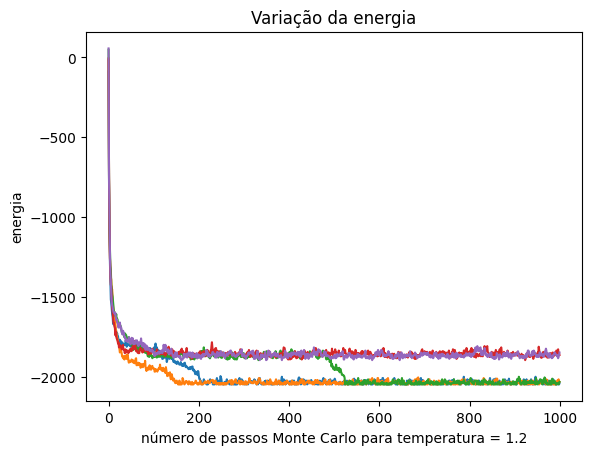

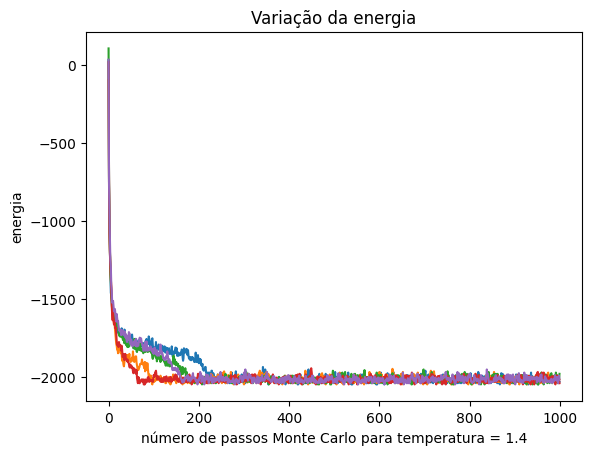

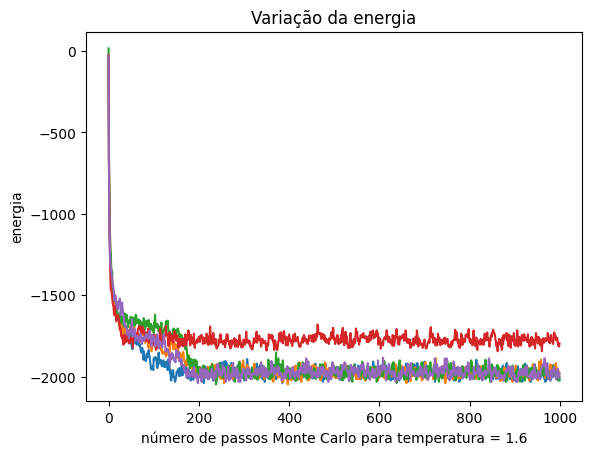

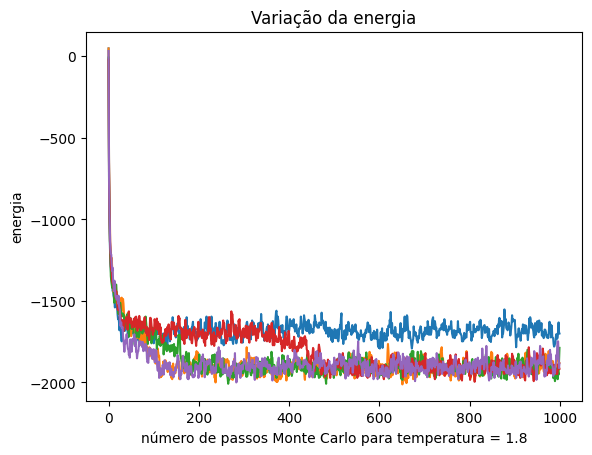

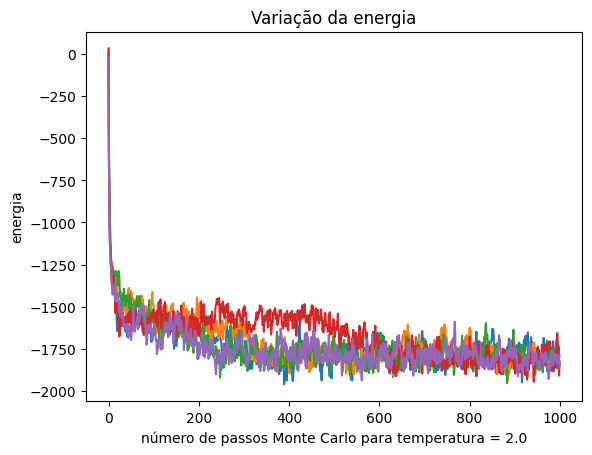

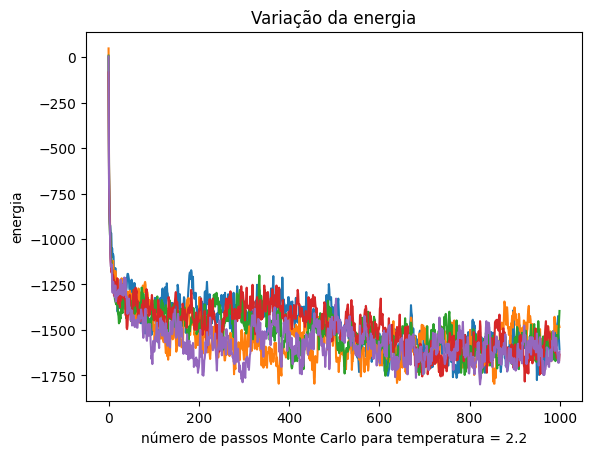

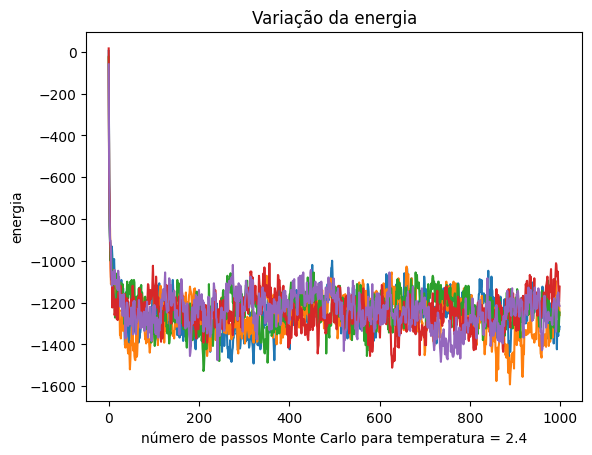

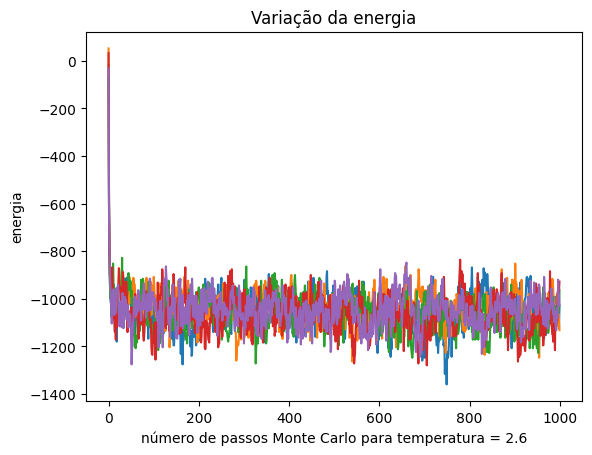

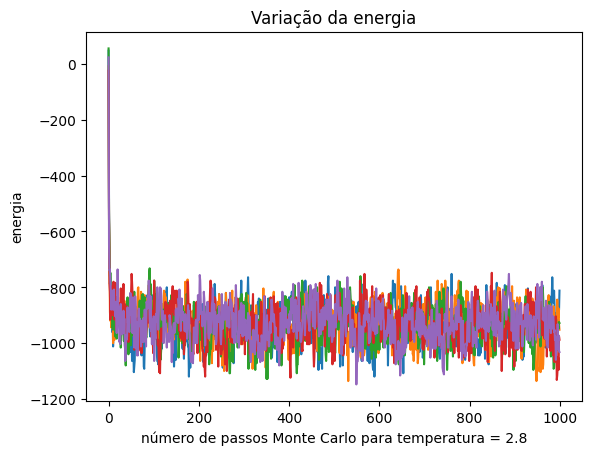

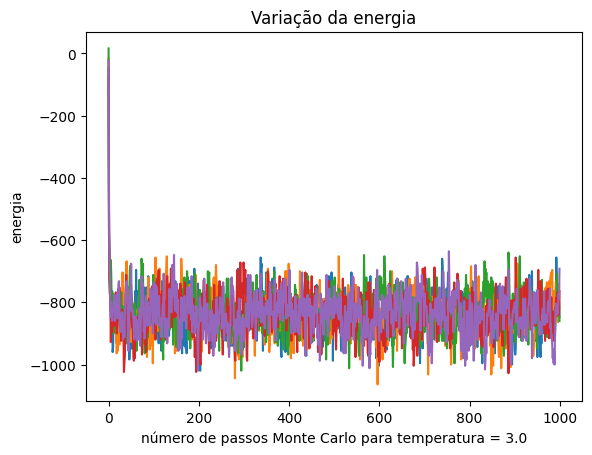

In [15]:
temp=temp_inicial
for i in range(0,arr_energias.shape[0],n):
    plotar_grafo_linha(arr_energias[i:i+n], "número de passos Monte Carlo para temperatura = " + str(round(temp,2)), "energia", "Variação da energia")
    temp=temp+step

## TABELA DE TESTES

    Tamanho da rede(L): 24 < L < 100
     
       32, 64, 96

    Temperatura(T): 0.4 < T < 3.0
    
        0.4, 1.7, 3.0

Escolhemos os valores 32, 64 e 96 de tamanho para rede para podermos testar redes de tamanho pequeno, médio e grande dentro da especificação do trabalho;

Para a temperatura seguimos a mesma lógica, utilizando 0.4 e 3.0 que são valores em ambos os extremos, e 1.7 que é um valor central do intervalo;


Para cada uma das possíveis combinações de L e de T expostas acima utilizamos o algoritmo de metropolis 5 vezes com 1000 passos de teste, com cada uma dessas iterações utilizando uma rede diferente gerada aleatoriamente com o tamanho L definido. Abaixo estão os gráficos de magnetização e energia para cada um dessas combinações.



Graficos para L =  32  e temperatura =  0.4


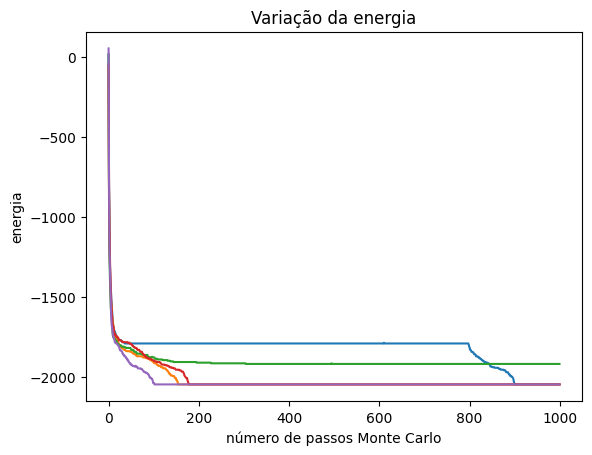

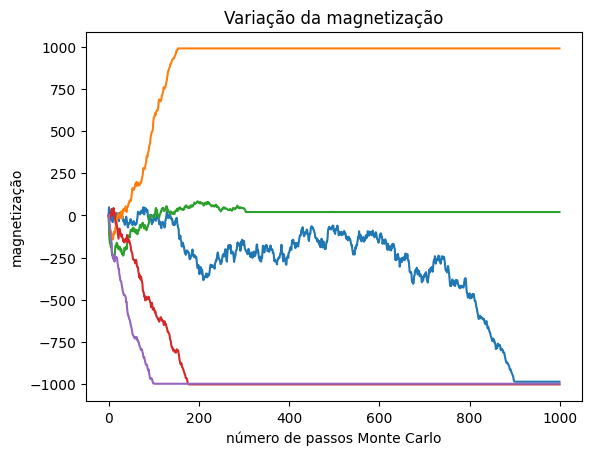

Graficos para L =  64  e temperatura =  0.4


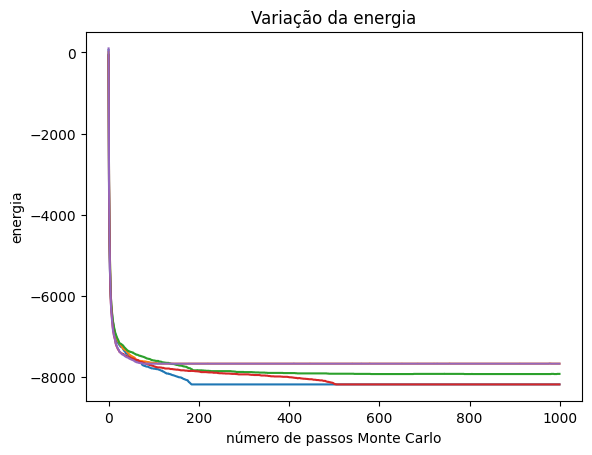

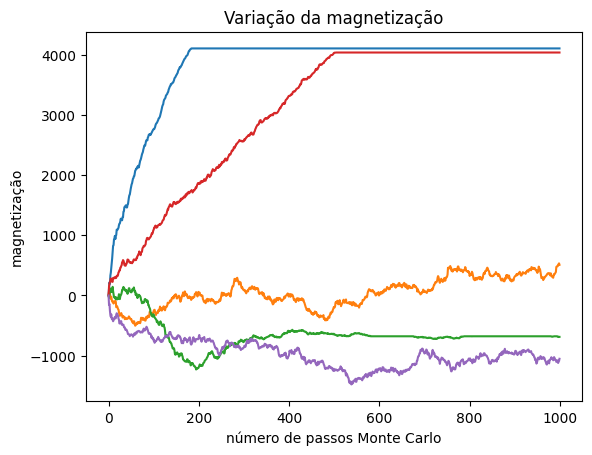

Graficos para L =  96  e temperatura =  0.4


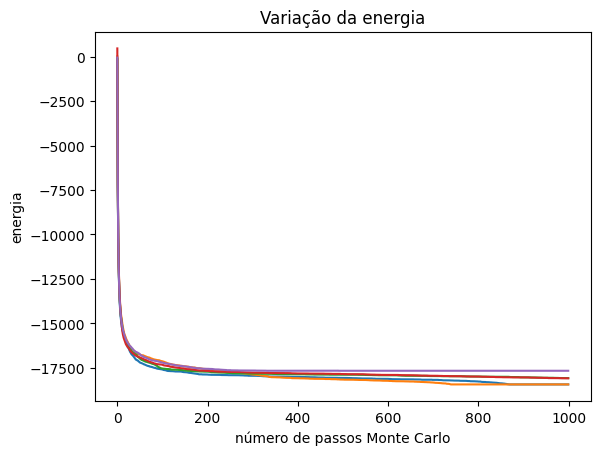

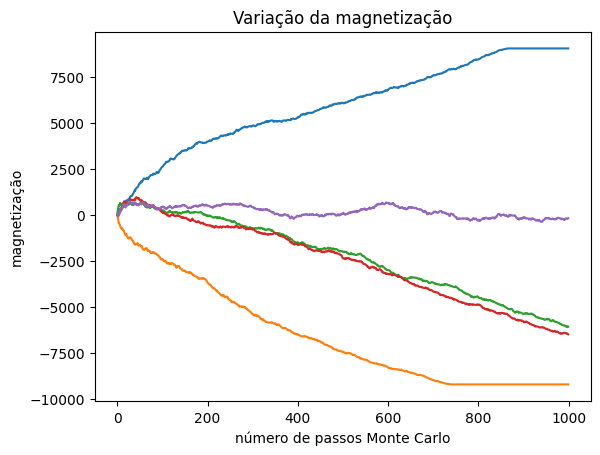

Graficos para L =  32  e temperatura =  1.7


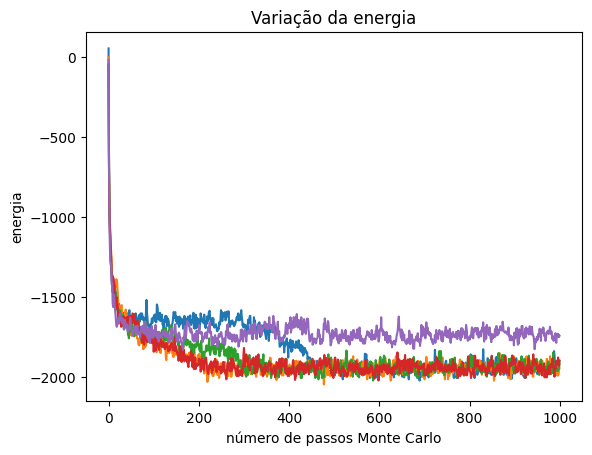

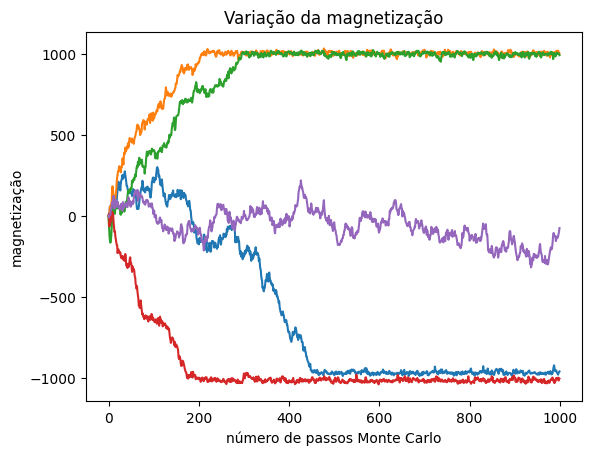

KeyboardInterrupt: ignored

In [16]:
n_passos_teste = 1000
n_teste = 5
for temp in [0.4,1.7,3.0]:
    for L in [32, 64, 96]:
        N_teste = L**2
        beta_teste = 1 / temp
        arr_energias_teste, arr_magnetizacoes_teste = fazer_alg_metropolis_n_vezes(n_teste, L, temp, n_passos_teste)
        print("Graficos para L = ", L, " e temperatura = ", temp)
        plotar_grafo_linha(arr_energias_teste, "número de passos Monte Carlo", "energia", "Variação da energia")
        plotar_grafo_linha(arr_magnetizacoes_teste, "número de passos Monte Carlo", "magnetização", "Variação da magnetização")

Com esses gráficos é possível analizar quando ocorre a termalização para cada uma das nossas combinações


In [17]:
#COM BASE NA ENERGIA
dados = {
    'L = 32': [150, 400, "100*"],
    'L = 64': [400, 600, "100*"],
    'L = 96': [400, 400, "100*"]
}

# Lista de rótulos para as linhas
rotulos_linhas = ['T = 0.4', 'T = 1.7', 'T = 3.0']

# Criar um DataFrame com rótulos para as linhas
tabela = pd.DataFrame(dados, index=rotulos_linhas)

# Exibir a tabela
print("tabela baseada nos gráficos de energia")
tabela

tabela baseada nos gráficos de energia


,L = 32,L = 64,L = 96
T = 0.4,150,400,400
T = 1.7,400,600,400
T = 3.0,100*,100*,100*


Os valores com asterisco indicam incerteza, uma vez que a variação é muito grande a cada instante;

Percebe-se o aumento do número de passos necessários para termalizar com o aumento da temperatura, com exceção de T=3 em que não há certeza sobre o momento da termalização;

Além disso, percebe-se relação entre o aumento de L e a dificuldade de convergir, mas essa relação é mais fraca do que a relação com a magnetização;

Com o aumento da temperatura há um aumento da amplitude das mudanças de estado, e consequentemente variações na energia e magnetização, mesmo após a termalização, dificultando a análise da convergência;

Por isso, a termalização em condições de alta temperatura é vista como baixa, uma vez que a variação que ela apresenta cedo se mantém nos estados seguintes;

In [ ]:
#COM BASE NA Magnetização
dados_mag = {
    'L = 32': [200,"500*" ,"Não determinável" ],
    'L = 64': [450,700 , "Não determinável"],
    'L = 96': [500,"Não convergiu" , "Não determinável"]
}

# Lista de rótulos para as linhas
rotulos_linhas = ['T = 0.4', 'T = 1.7', 'T = 3.0']

# Criar um DataFrame com rótulos para as linhas
tabela_mag = pd.DataFrame(dados_mag, index=rotulos_linhas)

# Exibir a tabela
print("tabela baseada nos gráficos de magnetização")
tabela_mag

Percebe-se um grande efeito da temperatura na magnetização, não permitindo a análise em temperaturas mais altas devido a variação muito alta sem aparente convergência;

Além disso, percebe-se que o aumento na rede proporciona maior dificuldade em termalizar ao analisarmos a magnetização, algo que não foi necessariamente observado na energia;

O asterisco em um dos valores simboliza que a maioria dos testes convergiu mas um deles ainda não havia chegado a conversão no número de passos analisados.

# PDF 2

## Funções

In [18]:
# Cálculo do Erro Estatístico
from math import sqrt

def calc_stat_err(arr):
  avg = arr.mean()
  sum = ((avg - arr)**2).sum()
  err = sqrt(sum / (len(arr) - 1))
  return err


In [19]:
# Cálculo do Calor Específico
def calc_specific_heat(arr, beta, N, m):
  mean_energy = np.mean(np.mean(arr.reshape(-1, m), axis=1))
  mean_energy_squared = np.mean(np.mean((arr**2).reshape(-1, m), axis=1))
  specific_heat = (mean_energy_squared - mean_energy**2)*(beta**2)/N
  return specific_heat

In [20]:
# Cálculo da Susceptibilidade Magnética
def calc_magnet_susc(arr, beta, N, m):
  mean_energy = np.mean(np.mean(arr.reshape(-1, m), axis=1))
  mean_energy_squared = np.mean(np.mean((arr**2).reshape(-1, m), axis=1))
  magnet_susc = (mean_energy_squared - mean_energy**2)*beta/N
  return magnet_susc

In [78]:
def calc_spin_energy(arr, N, m): # arr = arr de energias
  return np.mean(np.mean(arr.reshape(-1, m), axis=1))

In [79]:
def calc_spin_mag(arr, N, m): # arr = arr de magnetizacao
  return (np.mean(np.mean(arr.reshape(-1, m), axis=1)) )/ N

In [23]:
def calc_arr_specific_heat(temp_inicial, arr_energias, N, m, step, n):
  pointsx = []
  pointsy = []
  beta = 1 / temp_inicial
  temp = temp_inicial
  for i in range(0,arr_energias.shape[0],n):
    heat=calc_specific_heat(arr_energias[i:i+n], beta, N, m)
    pointsy.append(heat)
    pointsx.append(temp)
    temp= temp + step
  return pointsx, pointsy

In [24]:
def calc_arr_mag_susc(temp_inicial, arr_magnetizacoes, m, step, n):
  pointsx = []
  pointsy = []
  beta = 1 / temp_inicial
  temp = temp_inicial
  for i in range(0,arr_energias.shape[0],n):
    susc=calc_magnet_susc(arr_magnetizacoes[i:i+n], beta, N, m)
    pointsy.append(susc)
    pointsx.append(temp)
    temp= temp + step
  return pointsx, pointsy

In [72]:
def calc_arr_spin_ener(temp_inicial, arr_energias, m, N, step, n):
  pointsx = []
  pointsy = []
  beta = 1 / temp_inicial
  temp = temp_inicial
  for i in range(0,arr_energias.shape[0],n):
    spin_energy = calc_spin_energy(arr_energias[i:i+n], N, m)
    pointsy.append(spin_energy)
    pointsx.append(temp)
    temp= temp + step
  return pointsx, pointsy


In [81]:
def calc_arr_spin_mag(temp_inicial, arr_magnetizacoes, m, N, step, n):
  pointsx = []
  pointsy = []
  beta = 1 / temp_inicial
  temp = temp_inicial
  for i in range(0,arr_magnetizacoes.shape[0],n):
    spin_mag = calc_spin_mag(arr_magnetizacoes[i:i+n], N, m)
    pointsy.append(spin_mag)
    pointsx.append(temp)
    temp= temp + step
  return pointsx, pointsy

In [31]:
def vary_temp(L, temp_inicial, limit, step, n_passos, n):
  #gerar n configurqaçp
  s = [random.choice([-1, 1]) for _ in range(L * L)]
  for temp in range(int(temp_inicial*100),int(limit*100+1),int(step*100)):
    temp = temp/100
    if (temp==temp_inicial):
      #trocar pra fzrt u,m vez con cada
        arr_energias, arr_magnetizacoes = fazer_alg_metropolis_n_vezes(n, L, temp, n_passos, s)
    else:
        arr_energias_aux, arr_magnetizacoes_aux = fazer_alg_metropolis_n_vezes(n, L, temp, n_passos, s)
        arr_energias= np.concatenate((arr_energias, arr_energias_aux),0)
        arr_magnetizacoes=np.concatenate((arr_magnetizacoes,arr_magnetizacoes_aux),0)
  return arr_energias, arr_magnetizacoes



## Testes

## Questões

### Questão 1



L = 32 \
T = 1.5 \
Nterm = 500 \
Nmcs = 1000 \


1) Escolhemos primeiramente L = 32 por possuir um tamanho relativamente pequeno para o intervalo recomendado, permitindo uma análise mais eficiente, com menos estados de energia possíveis e auxiliando na análise dos gráficos resultantes.


Outro parâmetro escolhido foi a temperatura inicial igual a 1.5, que pode ser considerada uma temperatura mediana no intervalo recomendado, permitindo analisar gráficos em que a amplitude de mudança de estados é visível mas não tão grande que atrapalhe a análise.


Para o número de passos para a termalização escolhemos 500 pois permite a convergência nos gráficos de energia e de magnetização como pode ser visto acima, para todos os 5 testes realizados. Em muitos testes, percebemos a termalização anterior a esse número de estados, mas com esse valor podemos aumentar a chance de chegarmos a um estado de equilíbrio.


Com o número de passos para a termalização definido, podemos calcular o número de passos para cálculo das médias termodinâmicas, nesse experimento escolhemos 500 passos, totalizando assim 1000 passos pecorridos no total e permitindo uma boa estimativa dos valores termodinâmicos

### Questão 2

In [32]:
L = 32
step = 0.2
temp_inicial = 0.4
n = 5
N = L * L
m = 100
arr_energias, arr_magnetizacoes = vary_temp(L, temp_inicial, limit = 3.0, step=step, n_passos = 1000, n = n)
pontos_heatx, pontos_heaty = calc_arr_specific_heat(temp_inicial, arr_energias[:,500:], N = N , m= m, step = step, n = n)
pontos_suc_magx, pontos_suc_magy = calc_arr_mag_susc(temp_inicial, arr_magnetizacoes[:500], m, step, n)
pontos_spin_enx, pontos_spin_eny = calc_arr_spin_ener(temp_inicial, arr_energias[:500], m = m, N = N, step = step, n = n)
pontos_spin_magx, pontos_spin_magy = calc_arr_spin_mag(temp_inicial, arr_magnetizacoes[:,500:],  m = m, N = N, step = step, n = n)

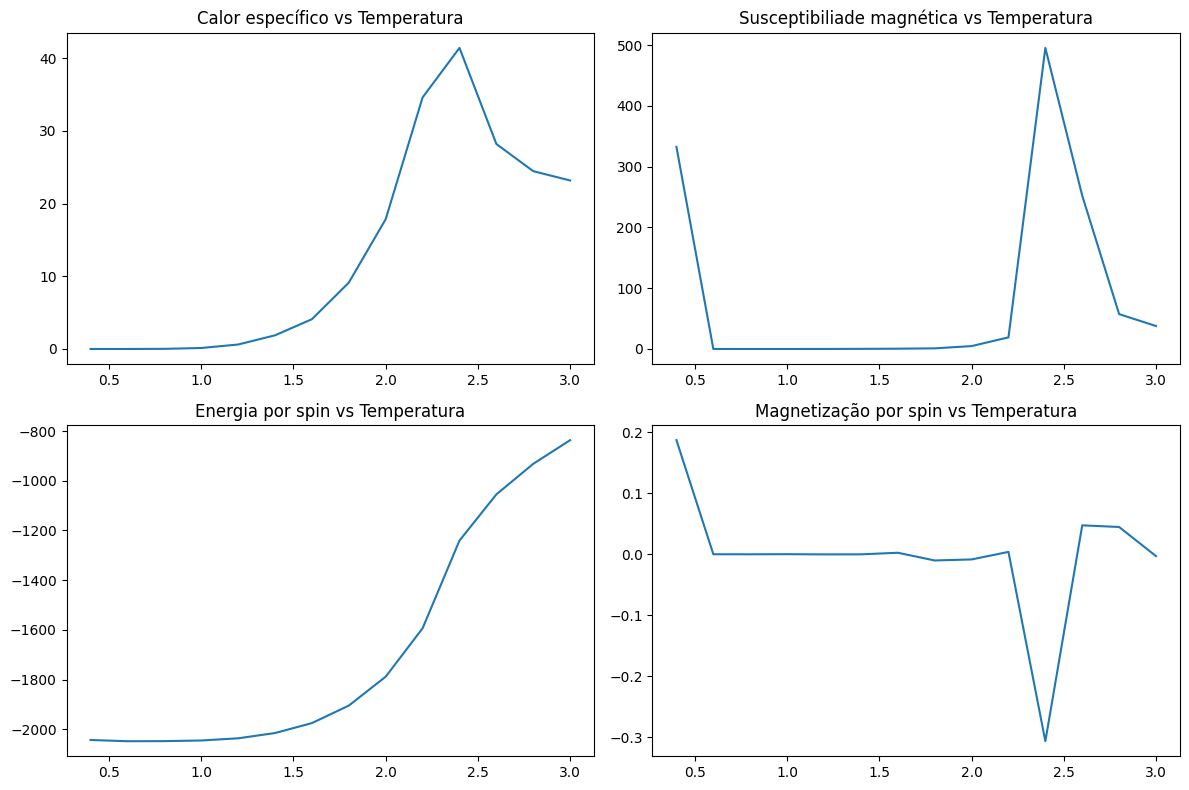

In [87]:
plt.figure(figsize=(12, 8))

# First subplot for pontos_heatx and pontos_heaty
plt.subplot(2, 2, 1)
plt.plot(pontos_heatx, pontos_heaty)
plt.title('Calor específico vs Temperatura')

# Second subplot for pontos_suc_magx and pontos_suc_magy
plt.subplot(2, 2, 2)
plt.plot(pontos_suc_magx, pontos_suc_magy)
plt.title('Susceptibilidade magnética vs Temperatura')

# Third subplot for pontos_spin_enx and pontos_spin_eny
plt.subplot(2, 2, 3)
plt.plot(pontos_spin_enx, pontos_spin_eny)
plt.title('Energia por spin vs Temperatura')

# Fourth subplot for the last pair
plt.subplot(2, 2, 4)
plt.plot(pontos_spin_magx, pontos_spin_magy)
plt.title('Magnetização por spin vs Temperatura')

plt.tight_layout()  # Ensures the subplots don't overlap

# Show the plots
plt.show()

2) Pelos grafos gerados ao longo de várias temperaturas, era esperado que a energia por spin aumentasse. O limite para baixas temperaturas da energia por spin é próximo de -2000 e para altas é próximo de -800.

  
  À medida que a temperatura aumenta, a agitação térmica começa a desordenar a orientação dos spins, reduzindo a magnetização. Isso é representado pelo "vale" na magnetização, onde a magnetização diminuiu. O limite para baixas temperaturas da magnetização por spin é próximo de 0.2 e para altas é próximo de 0.

  
  Em temperaturas mais baixas, os sistemas termodinâmicos têm menos energia térmica disponível, o que significa que eles têm menos "liberdade" para explorar diferentes configurações. Consequentemente, o calor específico começa a crescer à medida que a temperatura aumenta, pois a energia interna do sistema aumenta com a temperatura. À medida que a temperatura continua a aumentar, o sistema atinge um ponto crítico conhecido como temperatura crítica. Nesse ponto, o sistema passa por uma transição de fase, como a transição ferromagnética no modelo de Ising. À medida que a temperatura continua a aumentar além da temperatura crítica, o sistema se move para o estado de fase mista, e as flutuações críticas diminuem. Isso leva a uma diminuição na capacidade de calor, que eventualmente decai à medida que a temperatura aumenta. O limite para baixas temperaturas do calor específico é próximo de 0 e para altas é próximo de 15.

  
   Em temperaturas mais baixas, os spins tendem a se alinhar na mesma direção, resultando em uma alta magnetização e, por conseguinte, uma alta susceptibilidade magnética. À medida que a temperatura aumenta, a agitação térmica começa a desordenar a orientação dos spins, reduzindo a magnetização e, portanto, a susceptibilidade magnética também diminui. À medida que a temperatura continua a aumentar, o sistema se aproxima da temperatura crítica, onde as flutuações críticas se tornam mais proeminentes.  medida que a temperatura continua a aumentar além da temperatura crítica, o sistema entra em um estado de fase mista, onde a orientação dos spins não é tão ordenada quanto no estado ferromagnético. Isso resulta em uma queda na susceptibilidade magnética. O limite para baixas temperaturas da susceptibiliade magnética é próximo de 320 e para altas é próximo de 50.
